# ASE Filters

This notebook creates a set of filters for processing ASE results. These filters include:

* Mating Status: Exonic regions needs to be present in both mated and virgin
* APN: Exonic regions are required to have at least an APN of 25
* Exon Number: A genotype is required to have at least 500 exons after filtering
* Bias: A gnotype is kept if the median of its mated and virgin q5 mean $\theta$ is near 0.5 ($0.4 < \theta < 0.6$)

Below descirbes the cutoffs in more detail, shows the logic which came to these filters, and creates flags for use in downstream analysis.

In [1]:
# Set-up default environment
%run '../ipython_startup.py'

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt, mclib_Python/flagging as fg
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150827
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH


In [2]:
# Import additional libraries
import cPickle as pickle
from filterAgo import filterAgo

## Import Data

Import the Bayesian results table. This table includes: 

* q5 mean theta values for three empirical levels {0.4, 0.5, 0.6} and qsim
* The exonic region's mean APN
* Flags corresponding to allelic imbalance, including flag_AI_combined which uses the combination of the other AI flags to control TIER
* Raw counts

In [3]:
# Import Data
df = pd.read_csv(os.path.join(PROJ, 'pipeline_output/ase_bayesian_qsim_emp_theta_w_flag.csv'))
print(df.shape)
df.head()

(1939828, 19)


line mating_status  fusion_id  q4_mean_theta  q5_mean_theta  q6_mean_theta  \
0  r101             M  F10001_SI          0.572          0.480          0.387   
1  r101             M  F10005_SI          0.573          0.475          0.379   
2  r101             M  F10009_SI          0.645          0.565          0.475   
3  r101             M  F10012_SI          0.455          0.371          0.298   
4  r101             M  F10014_SI          0.359          0.284          0.219   

   qsim_mean_theta  flag_q4_AI  flag_q5_AI  flag_q6_AI  flag_all_AI  \
0            0.484           0           0           0            0   
1            0.476           1           0           1            0   
2            0.567           1           0           0            0   
3            0.375           0           0           0            0   
4            0.286           0           1           1            0   

   flag_AI_qsim  flag_AI_combined  qsim_line  sum_line  sum_tester  sum_both  \
0             0                 0   0.500000        23          19       628   
1             0                 0   0.500000       155         133      1274   
2             0                 0   0.500921        17          20       337   
3             0                 0   0.500000        12           6       433   
4             1                 0   0.500000        18           6       115   

   sum_total   mean_apn  
0        670  14.255319  
1       1562  29.523922  
2        374  13.238938  
3        451   8.947303  
4        139  10.392523

In [4]:
# Import drop list from 100 genome simulation
toDrop = pickle.load(open(os.path.join(PROJ, 'pipeline_output/100_genome_simulation/exonic_region_drop_list.pkl'), 'rb'))

# Drop exonic regions in drop list
print 'Original DataFrame has {} rows'.format(df.shape[0])
df = df[-df['fusion_id'].isin(toDrop)].copy()
print 'After dropping DataFrame has {} rows'.format(df.shape[0])

Original DataFrame has 1939828 rows
After dropping DataFrame has 1936215 rows


## Identify cutoffs

Here I plot q5 mean theta of mated against virgin. I am only plotting fusions that are in both mated and virgin. There are a lot of exonic regions that appear to either switch AI direction between mated and virgin or show AI in one and not in the other. The Bayesian model is sensitive to coverage, so it is possible that these are coverage artifacts.

Colors represent the following:
* 0: blue -> No AI
* 1: cyan -> Mated with AI
* 2: yellow -> Virgin with AI
* 3: red -> Mated and Virgin with AI

Keeping when flag_geno > 0.
Keeping when flag_bothMS > 0.
Min num exons: 7058
Max num exons: 17378

/home/jfear/.local/lib/python2.7/site-packages/pandas/core/indexing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jfear/.local/lib/python2.7/site-packages/pandas/core/indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


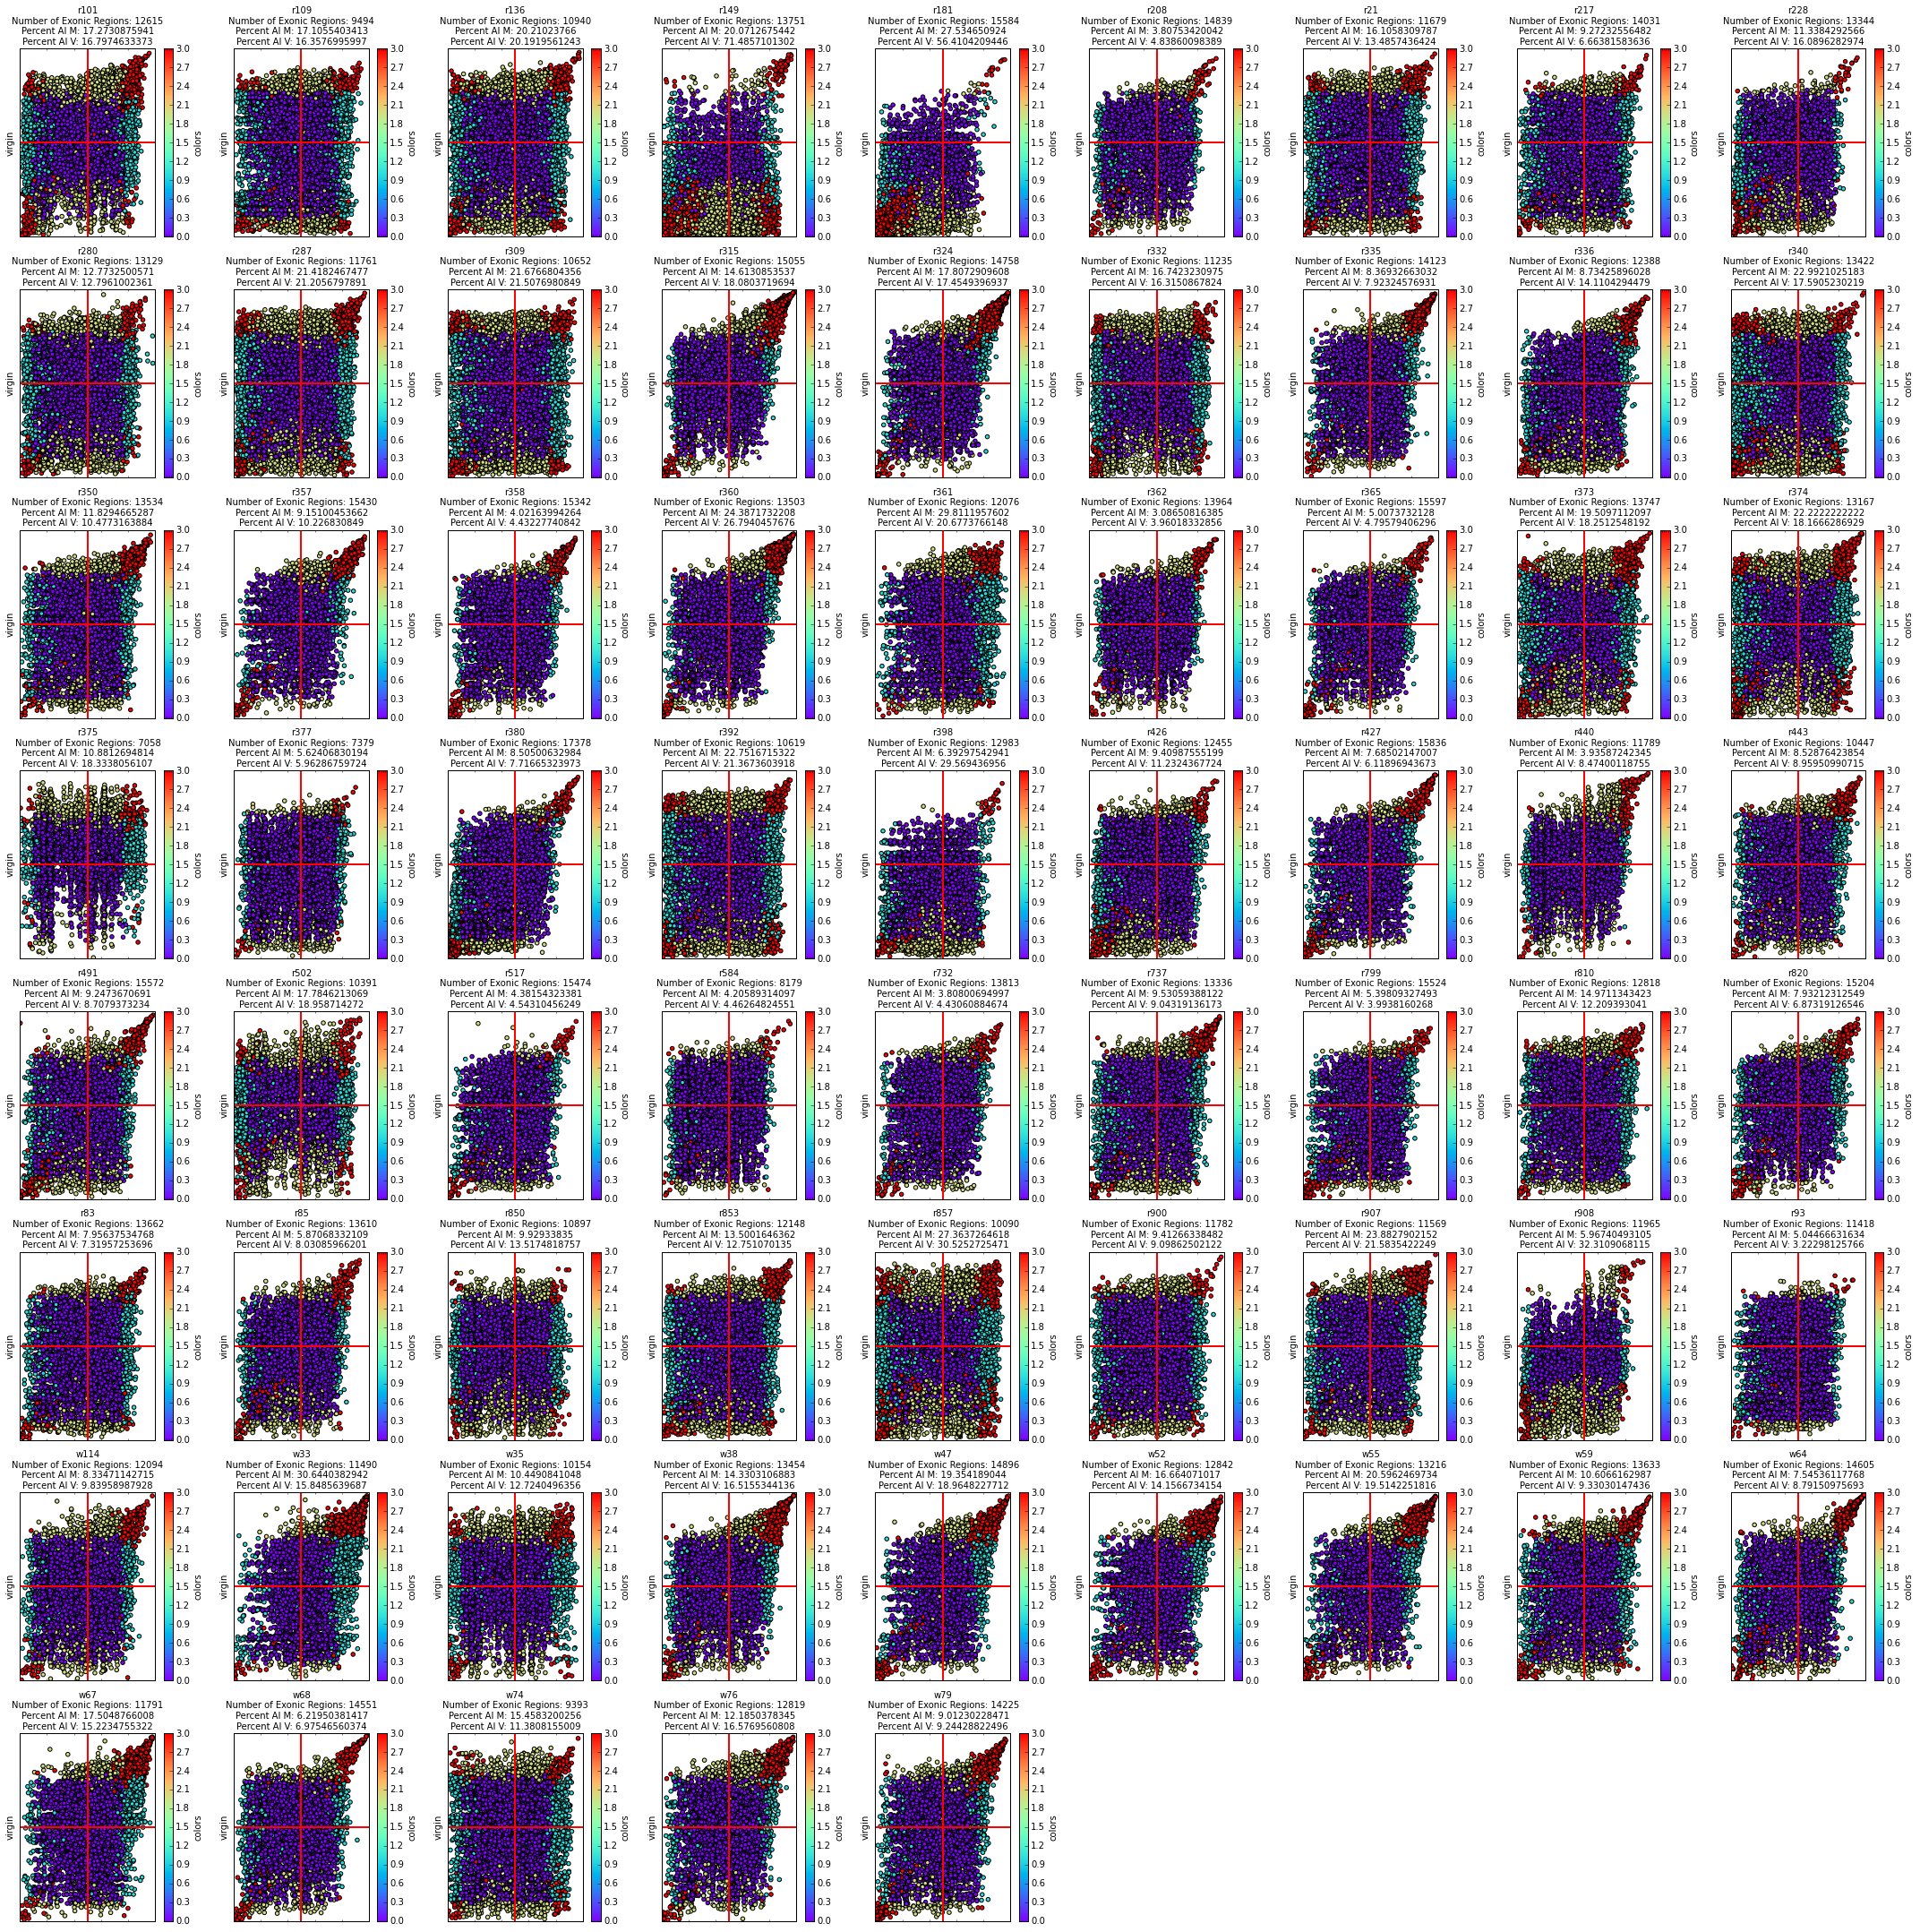

In [8]:
fusCnt, clean, flags = filterAgo(df, 0, 0, plot=True)

Now I use an interactive plot to adjust two cutoffs. The first cutoff is an APN cutoff. The second is the percent of genotypes an exonic regions must be expressed in. Below I summarize my findings.

In [14]:
from IPython.html.widgets import interact_manual, IntSlider, fixed
interact_manual(filterAgo, df=fixed(df), apn_cutoff=IntSlider(min=0, max=1000, value=25), per_geno_cutoff=IntSlider(min=0, max=100, value=10), plot=fixed(True))

<function filterAgo.filterAgo>

Here are some notes that I took on different settings.

* APN $\ge$ 50 and Genotypes $\gt$ 50%
    * Number of exonic regions: (14, 340)
    * Lines with fewer than 200 exons: r109, r21, r309, r332, r361, r375, r377, r392, r398, r426, r440, r584, r810, r850, r900, r908, r93, w114, w33, w35, w74 (n=21)

* APN $\ge$ 50 and Genotypes $\gt$ 25%
    * Number of exonic regions: (20, 796)
    * Lines with fewer than 200 exons: r109, r332, r375, r377, r398, r426, r440, r584, r850, r900, r908, r93, w33, w35, w74 (n=15)

* APN $\ge$ 50 and Genotypes $\gt$ 10%
    * Number of exonic regions: (23, 1505)
    * Lines with fewer than 200 exons: r109, r375, r377, r440, r584, r850, r908, r93, w33, w35, w74 (n=11)
    * Lines with fewer than 500 exons: 'r109', 'r136', 'r21', 'r228', 'r287', 'r309', 'r332', 'r336', 'r361', 'r362', 'r375', 'r377', 'r392', 'r398', 'r426', 'r440', 'r443', 'r502', 'r584', 'r810', 'r83', 'r850', 'r853', 'r857', 'r900', 'r907', 'r908', 'r93', 'w114', 'w33', 'w35', 'w67', 'w74' (n=33)

* APN $\ge$ 50 and Genotypes $\gt$ 5%
    * Number of exonic regions: (24, 1832)
    * Lines with fewer than 200 exons: r109, r375, r377, r440, r584, r850, r908, r93, w33, w35, w74 (n=11)

----

* APN $\ge$ 25 and Genotypes $\gt$ 50%
    * Number of exonic regions: (32, 744)
    * Lines with fewer than 200 exons: 'r375', 'r377', 'r584', 'r850', 'r908', 'r93', 'w35', 'w74' (n=8)

* APN $\ge$ 25 and Genotypes $\gt$ 25%
    * Number of exonic regions: (51, 1741)
    * Lines with fewer than 200 exons: 'r375', 'r377', 'r584', 'r93', 'w35' (n=5)

* APN $\ge$ 25 and Genotypes $\gt$ 10%
    * Number of exonic regions: (56, 3400)
    * Lines with fewer than 200 exons: 'r375', 'r93', 'w35' (n=3)
    * Lines with fewer than 500 exons: 'r109', 'r332', 'r375', 'r377', 'r440', 'r584', 'r850', 'r900', 'r908', 'r93', 'w33', 'w35', 'w74' (n=13)

* APN $\ge$ 25 and Genotypes $\gt$ 5%
    * Number of exonic regions: (57, 3969)
    * Lines with fewer than 200 exons: 'r375', 'r93' (n=2)


## APN Filters

I have settled on the following coverage filters, plots are below.

* Exon must be in mated and virgin
* Exon must have APN $\ge$ 25
* Exon must be in 10% of genotypes

In [4]:
fusCnt, clean, flags = filterAgo(df, apn_cutoff=25, per_geno_cutoff=10, plot=True)

Keeping when flag_geno > 0.
Keeping when flag_bothMS > 0.
Min num exons: 55
Max num exons: 3393

/home/jfear/.local/lib/python2.7/site-packages/pandas/core/indexing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jfear/.local/lib/python2.7/site-packages/pandas/core/indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


KeyboardInterrupt: 

KeyboardInterrupt: 

### Look at r857 in more detail

In [7]:
import mpld3
from mpld3 import plugins

In [8]:
# Get r857
r857 = clean[clean['line'] == 'r857'].copy()

# Re-color
r857['colors'] = 0
r857.loc[r857['flag_AI_combined_m'] == 1, 'colors'] = 1
r857.loc[r857['flag_AI_combined_v'] == 1, 'colors'] = 2
r857.loc[(r857['flag_AI_combined_m'] == 1) & (r857['flag_AI_combined_v'] == 1), 'colors'] = 3

In [9]:
# Plot r857 with tooltips

# Custom css for tooltip (stole from internet)
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

# Columns I want in my tooltip
cols = ['fusion_id', 
        'q5_mean_theta_m', 'q5_mean_theta_v', 
        'qsim_line_m', 'sum_line_m', 'sum_tester_m', 'sum_both_m', 'flag_AI_combined_m',
        'qsim_line_v', 'sum_line_v', 'sum_tester_v', 'sum_both_v', 'flag_AI_combined_v',
        'mean_apn_m', 'mean_apn_v']

# Generate list of lables 
labels = []
for fusion in r857['fusion_id'].values:
    label = r857.loc[r857['fusion_id'] == fusion, cols].T
    label.columns = ['']
    labels.append(str(label.to_html()))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scatter = ax.scatter(x=r857['q5_mean_theta_m'], y=r857['q5_mean_theta_v'], c=r857['colors'], cmap='rainbow', s=30)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('q5 Mean theta Mated')
ax.set_ylabel('q5 Mean theta Virgin')
ax.plot([0.5, 0.5], [-999, 999], color='r', lw=2)
ax.plot([-999, 999],[0.5, 0.5], color='r', lw=2)
ax.set_title('r857: by Line, by Environment')

# Add tooltip to plot
tooltip = plugins.PointHTMLTooltip(scatter, labels, voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

# Display and save
mpld3.save_html(fig, '/home/jfear/Desktop/r857.html')

Looking at these plots I can tell that there are some genotypes that have very few exonic regions that meet these criteria. I will remove a genotype if it does not have a minimum of 500 exonic regions remaining.

Lines to drop because they have too few exonic regions: r109, r332, r375, r377, r440, r584, r850, r900, r908, r93, w33, w35, w74
Number of Lines: 13


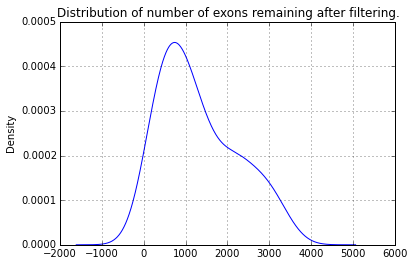

In [16]:
# Distribution of the number of fusions
fusCnt.plot(kind='kde', title='Distribution of number of exons remaining after filtering.')

# Count the number of fusions after filtering
flag_fusCnt = pd.DataFrame((fusCnt <= 500).astype(int))
flag_fusCnt.columns = ['flag_lt_500_exons']
print("Lines to drop because they have too few exonic regions: " + ', '.join(fusCnt[fusCnt <= 500].index.tolist()))
print("Number of Lines: " + str(len(fusCnt[fusCnt <= 500].index.tolist())))

## Bias Filters

After APN filters there are additional genotypes that show extreme bias. These can be seen as a point mass off 0.5. I want to remove genes where the point mass is off of 0.5 for mated or virgin. I will set the threshold such that if the median of $\theta$ for the genotype is less than 0.4 or greater than 0.6 then I will remove those lines.

These lines need to be removed:

In [17]:
# Look at median value of q5_theta for biased exonic regions
med = clean[['line', 'fusion_id', 'q5_mean_theta_m', 'q5_mean_theta_v']].groupby(['line']).median()

flag_bias = pd.DataFrame(((med['q5_mean_theta_m'] <= 0.4) | (med['q5_mean_theta_v'] <= 0.4) | (med['q5_mean_theta_m'] >= 0.6) | (med['q5_mean_theta_v'] >= 0.6)).astype(int))
flag_bias.columns = ['flag_genotype_bias']

baisLines = med[flag_bias['flag_genotype_bias'] == 1]
print("Lines that are biased: " + ', '.join(baisLines.index.tolist()))

Lines that are biased: r149, r181, r228, r336, r361, r375, r398, r908, w33


### Compare to Contaminated List

During the data cleaning process we identified a set of genotypes that appeared to have contamination. All of these genotypes:

['r149', 'r181', 'r228', 'r336', 'r361', 'r375', 'r398', 'r908', 'w33']

Were flagged in this list. 

The following were also flagged, but do not stand out above:

r357, r426, r810, r820, r907, w47

There were also a few replicates replicates that looked contaminated:

r502, r517, r83, r85, r853, w64, w67

In [5]:
fusCnt, clean, flags = filterAgo(df, apn_cutoff=25, per_geno_cutoff=10, plot=False)

Keeping when flag_geno > 0.
Keeping when flag_bothMS > 0.
Min num exons: 55
Max num exons: 3393


In [6]:
clean.head()

line mating_status_m  fusion_id  q4_mean_theta_m  q5_mean_theta_m  \
0  r101               M  F10005_SI            0.573            0.475   
1  r101               M  F10136_SI            0.862            0.812   
2  r101               M  F10268_SI            0.746            0.667   
3  r101               M  F10317_SI            0.157            0.110   
4  r101               M  F10806_SI            0.679            0.596   

   q6_mean_theta_m  qsim_mean_theta_m  flag_q4_AI_m  flag_q5_AI_m  \
0            0.379              0.476             1             0   
1            0.747              0.812             1             1   
2            0.574              0.664             1             1   
3            0.077              0.112             1             1   
4            0.510              0.597             1             0   

   flag_q6_AI_m     ...      flag_q6_AI_v  flag_all_AI_v  flag_AI_qsim_v  \
0             1     ...                 1              1               1   
1             1     ...                 1              1               1   
2             1     ...                 1              1               1   
3             1     ...                 1              1               1   
4             0     ...                 0              0               0   

   flag_AI_combined_v  qsim_line_v  sum_line_v  sum_tester_v  sum_both_v  \
0                   1          0.5         454           377        4444   
1                   1          0.5         249           492        3067   
2                   1          0.5         312           567        2042   
3                   1          0.5         679            62        5224   
4                   0          0.5          50            54        1866   

   sum_total_v  mean_apn_v  
0         5275   99.704666  
1         3808  194.969600  
2         2921  223.617225  
3         5965   89.910504  
4         1970   77.254902  

[5 rows x 36 columns]

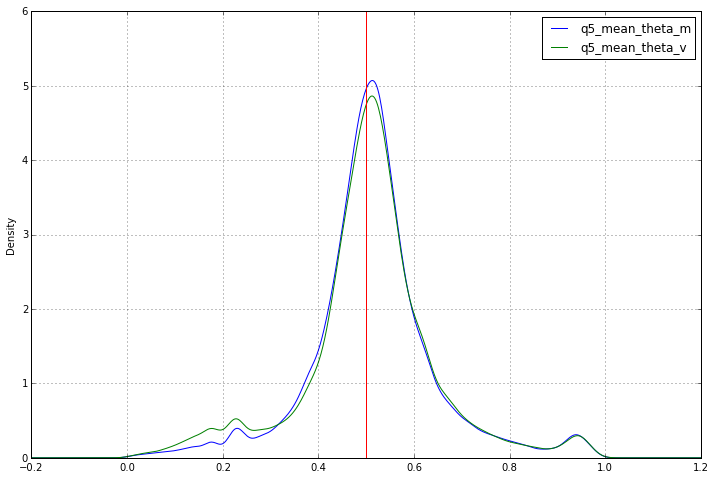

In [12]:
ax = clean[['q5_mean_theta_m', 'q5_mean_theta_v']].plot(kind='kde', figsize=(12, 8), xlim=(-0.2, 1.2))
ax.axvline(0.5, color='r', lw=1)
plt.savefig('/home/jfear/Desktop/dist.png')